In [2]:
try:
    import openmdao.api as om
    import dymos as dm
except ImportError:
    !python -m pip install openmdao[notebooks]
    !python -m pip install dymos
    import openmdao.api as om
    import dymos as dm

# Aircraft Balanced Field Length Calculation

```{admonition} Things you'll learn through this example
- How to perform branching trajectories
- How to constraint the difference between values at the end of two different phases
- Using complex-step differentiation on a monolithic ODE component
```

The United States Federal Aviation Regulations Part 25 defines a
balanced field length for the aircraft as the shortest field which can
accommodate a "balanced takeoff".  In a balanced takeoff the aircraft
accelerates down the runway to some critical speed "V1".

Before achieving V1, the aircraft must be capable of rejecting the takeoff
and coming to a stop before the end of the runway.

After V1, the aircraft must be capable of achieving an altitude of 35 ft
above the end of the runway with a speed of V2 (the minimum safe takeoff
speed or 1.2 x the stall speed) while on a single engine (for two engine aircraft).

At V1, both options must be available. The nominal phase sequence for this trajectory is:

1. Break Release to V1 (br_to_v1)

    Accelerate down the runway under the power of two engines.
    Where V1 is some as-yet-undetermined speed.

2. V1 to Vr (v1_to_vr)

    Accelerate down the runway under the power of a single engine.
    End at "Vr" or the rotation speed.
    The rotation speed here is defined as 1.2 times the stall speed.

3. Rotate (rotate)

    Operating under the power of a single engine, begin pitching the nose
    up (increasing alpha) while rolling down the runway.
    In this example, the rate of change of alpha is linear over some time.

4. Climb (climb)

    Still operating with one engine, begin climbing to a flight path angle
    of no more than 5 degrees.
    This phase ends when the aircraft is 35 feet above the ground with an airspeed
    of 1.25 x the stall speed.

5. Rejected Takeoff (rto)

    Shut down all engines (zero thrust) and apply brakes (increase of
    runway $\mu$ coefficient to 0.3) until the aircraft airspeed is zero.

    This phase is continuous in time and state with the first phase, and so
    forms a branch off of the nominal trajectory.

Since the RTO phase and the climb phase both must end such that they
do not exceed the end of the runway, the final value of range in each
of these two phases must be the same.  We don't know what this value is
until we've solved the problem, so we cannot simply constrain both to
the same fixed value.

Instead, we'll use a trajectory linkage constraint to ensure that `range`
at the end of the RTO phase is equal to `range` and the end of the climb phase.

More information on calculating the balanced field length is available
in section 17.8 of _Aircraft Design: A Conceptual Approach_ by
Daniel Raymer {cite}`raymer2012aircraft`.

## The ODE System

In this problem two sets of ordinary differential equations are used:
one for the aircraft motion on the runway, and one for the aircraft motion once airborne.

For simplification, we're going to assume a constant atmospheric model since the aircraft will never exceed 35 feet of altitude.
Also, since the duration of the trajectory is small, we're going to assume that the vehicle fuel burn is negligible

### The Aerodynamic Model

Both sets of equations of motion have common aerodynamic models.

First, the lift coefficient is computed using a model which assumes linearity in lift wrt the angle of attack.

\begin{align}
    C_L &= C_{L0} + \frac{\alpha}{\alpha_{max}} \left(C_{L-max} - C_{L0}\right)
\end{align}

Next, the drag-due-to-lift factor is computed (Equations 12.48 and 12.61 in Raymer[@raymer2012aircraft]).

\begin{align}
    K_{nom} &= \frac{1}{ \pi  AR  e} \\
    b &= \frac{span}{2} \\
    K &= 33 K_{nom} \frac{ \left(\frac{h + h_w}{b} \right) ^{\frac{3}{2}}}{1.0 + 33 \left( \frac{h + h_w}{b}\right) ^{\frac{3}{2}}}
\end{align}

Note the singularity in the equation for $K$ when $h + h_w$ is negative.
This causes this problem to be difficult to solve using a shooting method.
If the optimizer proposes a combination of initial states and a control history that results in altitude dropping significantly below zero, the propagation will fail.

Finally, the lift and drag are computed after computing the dynamic pressure.

\begin{align}
    q &= 0.5 \rho v^2 \\
    L &= q  S  C_L \\
    D &= q S \left( C_{D0} + K C_{L}^2 \right)
\end{align}

### Stall Speed

This model relies on the ratio of the current true airspeed to stall speed ($\frac{v}{v_{stall}}$).
This constraint is used to trigger the beginning of rotation and is used as a boundary constraint at the end of the initial climb.
Stall speed is given by Equation 5.6 in Raymer[@raymer2012aircraft].

\begin{align}
    W &= m g \\
    v_{stall} &= \sqrt{\frac{2 * W}{\rho S C_{L-max}}}
\end{align}

### Runway Equations of Motion

The runway equations of motion are used to integrate range and speed as the vehicle rolls along the runway.

\begin{align}
  F_r &= mg - L \cos \alpha - T \sin \alpha \\
  \dot{v} &= \frac{T \cos \alpha - D - F_r \mu_r}{m} \\
  \dot{r} &= v
\end{align}


|State  | Description           |Units        |
|-------|-----------------------|-------------|
|r      |range                  |$m$          |
|v      |true airspeed          |$m s^{-1}$   |


### Flight Equations of Motion

The flight equations of motion include two additional state variables: the flight-path angle ($\gamma$) and altitude ($h$).

\begin{align}
  \dot{v} &= \frac{T}{m} \cos \alpha - \frac{D}{m} - g \sin \gamma \\
  \dot{\gamma} &= \frac{T}{m v} \sin \alpha + \frac{L}{m v} - \frac{g \cos \gamma}{v} \\
  \dot{h} &= v \sin \gamma \\
  \dot{r} &= v \cos \gamma
\end{align}

|State    | Description           |Units       |
|---------|-----------------------|------------|
|v        |true airspeed          |$m s^{-1}$  |
|$\gamma$ |flight path angle      |$rad$       |
|r        |range                  |$m$         |
|h        |altitude               |$m$         |


### Treatment of the angle-of-attack ($\alpha$)

In three of the runway phases (break release to $V1$, $V1$ to $V_r$, and rejected takeoff) $\alpha$ is treated as a fixed static parameter.

In the rotation phase, $\alpha$ is treated as a polynomial control of order 1.
$\alpha$ starts at an initial value of zero and increases at a linear rate until the upward forces on the aircraft due to lift and thrust cancel the downward force due to gravity.

In the climb phase, $\alpha$ is treated as a dynamic control to be chosen by the optimizer.

Phase linkage constraints are used to maintain continuity in $\alpha$ throughout the trajectory.

### Parameters

The following parameters define properties of the aircraft and environment for the problem.

|Parameters  | Description               |Units        |Value                    |
|------------|---------------------------|-------------|-------------------------|
|m           |mass                       |$kg$         | 79015.7909              |
|g           |gravitational acceleration |$m s^{-2}$   | 9.80665                 |
|T           |thrust                     |$N$          | 2 x 120101.98 (nominal) |
|$\mu$       |runway friction coefficient|-            | 0.03 (nominal)          |
|h           |altitude                   |$m$          | 0                       |
|$\rho$      |atmospheric density        |$kg\,m^{3}$  | 1.225                   |
|S           |aerodynamic reference area |$m^2$        | 124.7                   |
|CD0         |zero-lift drag coefficient |-            | 0.03                    |
|AR          |wing aspect ratio          |-            | 9.45                    |
|e           |Oswald's wing efficiency   |-            | 801                     |
|span        |wingspan                   |$m$          | 35.7                    |
|h_w         |height of wing above CoG   |$m$          | 1.0                     |
|CL0         |aerodynamic reference area |-            | 0.5                     |
|CL_max      |aerodynamic reference area |-            | 2.0                     |

## The Optimal Control Problem

The following constraints and objective complete the definition of this optimal control problem.

### Objective

|Name   | Phase     | Location | Description | Minimized or Maximized | Ref  |
|-------|-----------|----------|-------------|------------------------|------|
| r     | rto       | final    | range       | Minimized              | 1000 |

### Nonlinear Boundary Constraints

|Name              | Phase    | Description           | Loc   | Units     | Lower  | Upper | Equals | Ref    |
|------------------|----------|-----------------------|-------|-----------|--------|-------|--------|--------|
| v_over_v_stall   | v1_to_vr | $\frac{v}{v_{stall}}$ | final | -         | 1.2    |       |        | 1.2    |
| v                | rto      | airspeed              | final | $ms^{-1}$ |        |       | 0      | 100    |
| F_r              | rotate   | downforce on gear     | final | $N$       |        |       | 0      | 100000 |
| h                | climb    | altitude              | final | $ft$      |        |       | 35     | 35     |
| gam              | climb    | flight path angle     | final | $rad$     |        |       | 5      | 5      |
| v_over_v_stall   | climb    | $\frac{v}{v_{stall}}$ | final | -         | 1.25   |       |        | 1.25   |

### Nonlinear Path Constraints

|Name              | Phase    | Description         | Units     | Lower  | Upper | Equals | Ref    |
|------------------|----------|---------------------|-----------|--------|-------|--------|--------|
| gam              | climb    | flight path angle   | $rad$     | 0      | 5     |        | 5      |

### Phase Continuity Constraints

| First Phase      | Second Phase      | Variables                   |
|------------------|-------------------|-----------------------------|
| br_to_v1[final]  | v1_to_vr[initial] | $time$, $r$, $v$            |
| vr_to_v1[final]  | rotate[initial]   | $time$, $r$, $v$, $\alpha$  |
| rotate[final]    | climb[initial]    | $time$, $r$, $v$, $\alpha$  |
| br_to_v1[final]  | rto[initial]      | $time$, $r$, $v$            |
| climb[final]     | rto[final]        | $r$                         |

## Source Code

Unlike most other Dymos examples, which use analytic derivatives, the ODE in this case is a single component.
All calculations within the ODE are complex-safe and thus we can use complex-step, in conjunction with
[partial derivative coloring](http://openmdao.org/twodocs/versions/latest/features/experimental/simul_coloring_fd_cs.html),
to automatically compute the derivatives using complex-step with reasonable speed.

Since there is significant commonality between the ODEs for the runway roll and the climb, this implementation
uses a single ODE class with an option `mode` that can be set to either `'runway'` or `'climb'`.
Based on the value of `mode`, the component conditionally changes its inputs and outputs.

### BalancedFieldODEComp

In [5]:
class BalancedFieldODEComp(om.ExplicitComponent):
    """
    The ODE System for an aircraft takeoff climb.

    Computes the rates for states v (true airspeed) gam (flight path angle) r (range) and h (altitude).

    References
    ----------
    .. [1] Raymer, Daniel. Aircraft design: a conceptual approach. American Institute of
    Aeronautics and Astronautics, Inc., 2012.
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('g', types=(float, int), default=9.80665, desc='gravitational acceleration (m/s**2)')
        self.options.declare('mode', values=('runway', 'climb'), desc='mode of operation (ground roll or flight)')

    def setup(self):
        nn = self.options['num_nodes']

        # Scalar (constant) inputs
        self.add_input('rho', val=1.225, desc='atmospheric density at runway', units='kg/m**3')
        self.add_input('S', val=124.7, desc='aerodynamic reference area', units='m**2')
        self.add_input('CD0', val=0.03, desc='zero-lift drag coefficient', units=None)
        self.add_input('CL0', val=0.5, desc='zero-alpha lift coefficient', units=None)
        self.add_input('CL_max', val=2.0, desc='maximum lift coefficient for linear fit', units=None)
        self.add_input('alpha_max', val=np.radians(10), desc='angle of attack at CL_max', units='rad')
        self.add_input('h_w', val=1.0, desc='height of the wing above the CG', units='m')
        self.add_input('AR', val=9.45, desc='wing aspect ratio', units=None)
        self.add_input('e', val=0.801, desc='Oswald span efficiency factor', units=None)
        self.add_input('span', val=35.7, desc='Wingspan', units='m')
        self.add_input('T', val=1.0, desc='thrust', units='N')

        # Dynamic inputs (can assume a different value at every node)
        self.add_input('m', shape=(nn,), desc='aircraft mass', units='kg')
        self.add_input('v', shape=(nn,), desc='aircraft true airspeed', units='m/s')
        self.add_input('h', shape=(nn,), desc='altitude', units='m')
        self.add_input('alpha', shape=(nn,), desc='angle of attack', units='rad')

        # Outputs
        self.add_output('CL', shape=(nn,), desc='lift coefficient', units=None)
        self.add_output('q', shape=(nn,), desc='dynamic pressure', units='Pa')
        self.add_output('L', shape=(nn,), desc='lift force', units='N')
        self.add_output('D', shape=(nn,), desc='drag force', units='N')
        self.add_output('K', val=np.ones(nn), desc='drag-due-to-lift factor', units=None)
        self.add_output('F_r', shape=(nn,), desc='runway normal force', units='N')
        self.add_output('v_dot', shape=(nn,), desc='rate of change of speed', units='m/s**2',
                        tags=['dymos.state_rate_source:v'])
        self.add_output('r_dot', shape=(nn,), desc='rate of change of range', units='m/s',
                        tags=['dymos.state_rate_source:r'])
        self.add_output('W', shape=(nn,), desc='aircraft weight', units='N')
        self.add_output('v_stall', shape=(nn,), desc='stall speed', units='m/s')
        self.add_output('v_over_v_stall', shape=(nn,), desc='stall speed ratio', units=None)

        # Mode-dependent IO
        if self.options['mode'] == 'runway':
            self.add_input('mu_r', val=0.05, desc='runway friction coefficient', units=None)
        else:
            self.add_input('gam', shape=(nn,), desc='flight path angle', units='rad')
            self.add_output('gam_dot', shape=(nn,), desc='rate of change of flight path angle',
                            units='rad/s', tags=['dymos.state_rate_source:gam'])
            self.add_output('h_dot', shape=(nn,), desc='rate of change of altitude', units='m/s',
                            tags=['dymos.state_rate_source:h'])

        self.declare_coloring(wrt='*', method='cs')

    def compute(self, inputs, outputs, discrete_inputs=None, discrete_outputs=None):
        g = self.options['g']

        # Compute factor k to include ground effect on lift
        rho = inputs['rho']
        v = inputs['v']
        S = inputs['S']
        CD0 = inputs['CD0']
        m = inputs['m']
        T = inputs['T']
        h = inputs['h']
        h_w = inputs['h_w']
        span = inputs['span']
        AR = inputs['AR']
        CL0 = inputs['CL0']
        alpha = inputs['alpha']
        alpha_max = inputs['alpha_max']
        CL_max = inputs['CL_max']
        e = inputs['e']

        outputs['W'] = W = m * g
        outputs['v_stall'] = v_stall = np.sqrt(2 * W / rho / S / CL_max)
        outputs['v_over_v_stall'] = v / v_stall

        outputs['CL'] = CL = CL0 + (alpha / alpha_max) * (CL_max - CL0)
        K_nom = 1.0 / (np.pi * AR * e)
        b = span / 2.0
        fact = ((h + h_w) / b) ** 1.5
        outputs['K'] = K = K_nom * 33 * fact / (1.0 + 33 * fact)

        outputs['q'] = q = 0.5 * rho * v ** 2
        outputs['L'] = L = q * S * CL
        outputs['D'] = D = q * S * (CD0 + K * CL ** 2)

        # Compute the downward force on the landing gear
        calpha = np.cos(alpha)
        salpha = np.sin(alpha)

        # Runway normal force
        outputs['F_r'] = F_r = m * g - L * calpha - T * salpha

        # Compute the dynamics
        if self.options['mode'] == 'climb':
            gam = inputs['gam']
            cgam = np.cos(gam)
            sgam = np.sin(gam)
            outputs['v_dot'] = (T * calpha - D) / m - g * sgam
            outputs['gam_dot'] = (T * salpha + L) / (m * v) - (g / v) * cgam
            outputs['h_dot'] = v * sgam
            outputs['r_dot'] = v * cgam
        else:
            outputs['v_dot'] = (T * calpha - D - F_r * inputs['mu_r']) / m
            outputs['r_dot'] = v

## Building and running the problem

In the following code we define and solve the optimal control problem.
Note the use of `add_linkage_constraint` to handle the less common phase
linkage condition, where the range must be equal at the end of the `rto` and `climb` phases.

--- Linkage Report [traj] ---
    --- br_to_v1 - v1_to_vr ---
        time [final]  ==  time [initial]
        r    [final]  ==  r    [initial]
        v    [final]  ==  v    [initial]
----------------------------
    --- v1_to_vr - rotate ---
        time  [final]  ==  time  [initial]
        r     [final]  ==  r     [initial]
        v     [final]  ==  v     [initial]
        alpha [final]  ==  alpha [initial]
----------------------------
    --- rotate - climb ---
        time  [final]  ==  time  [initial]
        r     [final]  ==  r     [initial]
        v     [final]  ==  v     [initial]
        alpha [final]  ==  alpha [initial]
----------------------------
    --- br_to_v1 - rto ---
        time [final]  ==  time [initial]
        r    [final]  ==  r    [initial]
        v    [final]  ==  v    [initial]
----------------------------
    --- rto - climb ---
        r [final]  ==  r [final]
----------------------------
INFO: checking out_of_order
INFO: checking system
INFO: checki

/Users/dkilkenny/Desktop/OpenMDAO_Clone/openmdao/core/total_jac.py:1756: DerivativesWarning:Constraints or objectives [('traj.phases.climb.path_constraints.path:gam', inds=[(0, 0)])] cannot be impacted by the design variables of the problem.



Simulating trajectory traj
Done simulating trajectory traj
[2188.23307777]


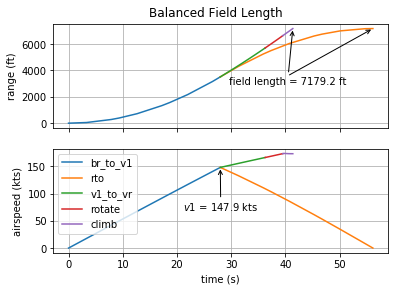

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import openmdao.api as om
from openmdao.utils.general_utils import set_pyoptsparse_opt
import dymos as dm

p = om.Problem()

_, optimizer = set_pyoptsparse_opt('IPOPT', fallback=True)

p.driver = om.pyOptSparseDriver()
p.driver.declare_coloring()

# Use IPOPT if available, with fallback to SLSQP
p.driver.options['optimizer'] = optimizer
p.driver.options['print_results'] = False
if optimizer == 'IPOPT':
    p.driver.opt_settings['print_level'] = 5
    p.driver.opt_settings['derivative_test'] = 'first-order'

# First Phase: Brake release to V1 - both engines operable
br_to_v1 = dm.Phase(ode_class=BalancedFieldODEComp, transcription=dm.Radau(num_segments=3),
                    ode_init_kwargs={'mode': 'runway'})
br_to_v1.set_time_options(fix_initial=True, duration_bounds=(1, 1000), duration_ref=10.0)
br_to_v1.add_state('r', fix_initial=True, lower=0, ref=1000.0, defect_ref=1000.0)
br_to_v1.add_state('v', fix_initial=True, lower=0, ref=100.0, defect_ref=100.0)
br_to_v1.add_parameter('alpha', val=0.0, opt=False, units='deg')
br_to_v1.add_timeseries_output('*')

# Second Phase: Rejected takeoff at V1 - no engines operable
rto = dm.Phase(ode_class=BalancedFieldODEComp, transcription=dm.Radau(num_segments=3),
               ode_init_kwargs={'mode': 'runway'})
rto.set_time_options(fix_initial=False, duration_bounds=(1, 1000), duration_ref=1.0)
rto.add_state('r', fix_initial=False, lower=0, ref=1000.0, defect_ref=1000.0)
rto.add_state('v', fix_initial=False, lower=0, ref=100.0, defect_ref=100.0)
rto.add_parameter('alpha', val=0.0, opt=False, units='deg')
rto.add_timeseries_output('*')

# Third Phase: V1 to Vr - single engine operable
v1_to_vr = dm.Phase(ode_class=BalancedFieldODEComp, transcription=dm.Radau(num_segments=3),
                    ode_init_kwargs={'mode': 'runway'})
v1_to_vr.set_time_options(fix_initial=False, duration_bounds=(1, 1000), duration_ref=1.0)
v1_to_vr.add_state('r', fix_initial=False, lower=0, ref=1000.0, defect_ref=1000.0)
v1_to_vr.add_state('v', fix_initial=False, lower=0, ref=100.0, defect_ref=100.0)
v1_to_vr.add_parameter('alpha', val=0.0, opt=False, units='deg')
v1_to_vr.add_timeseries_output('*')

# Fourth Phase: Rotate - single engine operable
rotate = dm.Phase(ode_class=BalancedFieldODEComp, transcription=dm.Radau(num_segments=3),
                  ode_init_kwargs={'mode': 'runway'})
rotate.set_time_options(fix_initial=False, duration_bounds=(1.0, 5), duration_ref=1.0)
rotate.add_state('r', fix_initial=False, lower=0, ref=1000.0, defect_ref=1000.0)
rotate.add_state('v', fix_initial=False, lower=0, ref=100.0, defect_ref=100.0)
rotate.add_polynomial_control('alpha', order=1, opt=True, units='deg', lower=0, upper=10, ref=10, val=[0, 10])
rotate.add_timeseries_output('*')

# Fifth Phase: Climb to target speed and altitude at end of runway.
climb = dm.Phase(ode_class=BalancedFieldODEComp, transcription=dm.Radau(num_segments=5),
                 ode_init_kwargs={'mode': 'climb'})
climb.set_time_options(fix_initial=False, duration_bounds=(1, 100), duration_ref=1.0)
climb.add_state('r', fix_initial=False, lower=0, ref=1000.0, defect_ref=1000.0)
climb.add_state('h', fix_initial=True, lower=0, ref=1.0, defect_ref=1.0)
climb.add_state('v', fix_initial=False, lower=0, ref=100.0, defect_ref=100.0)
climb.add_state('gam', fix_initial=True, lower=0, ref=0.05, defect_ref=0.05)
climb.add_control('alpha', opt=True, units='deg', lower=-10, upper=15, ref=10)
climb.add_timeseries_output('*')

# Instantiate the trajectory and add phases
traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)
traj.add_phase('br_to_v1', br_to_v1)
traj.add_phase('rto', rto)
traj.add_phase('v1_to_vr', v1_to_vr)
traj.add_phase('rotate', rotate)
traj.add_phase('climb', climb)

# Add parameters common to multiple phases to the trajectory
traj.add_parameter('m', val=174200., opt=False, units='lbm',
                   desc='aircraft mass',
                   targets={'br_to_v1': ['m'], 'v1_to_vr': ['m'], 'rto': ['m'],
                            'rotate': ['m'], 'climb': ['m']})

traj.add_parameter('T_nominal', val=27000 * 2, opt=False, units='lbf', static_target=True,
                   desc='nominal aircraft thrust',
                   targets={'br_to_v1': ['T']})

traj.add_parameter('T_engine_out', val=27000, opt=False, units='lbf', static_target=True,
                   desc='thrust under a single engine',
                   targets={'v1_to_vr': ['T'], 'rotate': ['T'], 'climb': ['T']})

traj.add_parameter('T_shutdown', val=0.0, opt=False, units='lbf', static_target=True,
                   desc='thrust when engines are shut down for rejected takeoff',
                   targets={'rto': ['T']})

traj.add_parameter('mu_r_nominal', val=0.03, opt=False, units=None, static_target=True,
                   desc='nominal runway friction coefficient',
                   targets={'br_to_v1': ['mu_r'], 'v1_to_vr': ['mu_r'],  'rotate': ['mu_r']})

traj.add_parameter('mu_r_braking', val=0.3, opt=False, units=None, static_target=True,
                   desc='runway friction coefficient under braking',
                   targets={'rto': ['mu_r']})

traj.add_parameter('h_runway', val=0., opt=False, units='ft',
                   desc='runway altitude',
                   targets={'br_to_v1': ['h'], 'v1_to_vr': ['h'], 'rto': ['h'],
                            'rotate': ['h']})

traj.add_parameter('rho', val=1.225, opt=False, units='kg/m**3', static_target=True,
                   desc='atmospheric density',
                   targets={'br_to_v1': ['rho'], 'v1_to_vr': ['rho'], 'rto': ['rho'],
                            'rotate': ['rho']})

traj.add_parameter('S', val=124.7, opt=False, units='m**2', static_target=True,
                   desc='aerodynamic reference area',
                   targets={'br_to_v1': ['S'], 'v1_to_vr': ['S'], 'rto': ['S'],
                            'rotate': ['S'], 'climb': ['S']})

traj.add_parameter('CD0', val=0.03, opt=False, units=None, static_target=True,
                   desc='zero-lift drag coefficient',
                   targets={f'{phase}': ['CD0'] for phase in ['br_to_v1', 'v1_to_vr',
                                                              'rto', 'rotate' 'climb']})

traj.add_parameter('AR', val=9.45, opt=False, units=None, static_target=True,
                   desc='wing aspect ratio',
                   targets={f'{phase}': ['AR'] for phase in ['br_to_v1', 'v1_to_vr',
                                                             'rto', 'rotate' 'climb']})

traj.add_parameter('e', val=801, opt=False, units=None, static_target=True,
                   desc='Oswald span efficiency factor',
                   targets={f'{phase}': ['e'] for phase in ['br_to_v1', 'v1_to_vr',
                                                            'rto', 'rotate' 'climb']})

traj.add_parameter('span', val=35.7, opt=False, units='m', static_target=True,
                   desc='wingspan',
                   targets={f'{phase}': ['span'] for phase in ['br_to_v1', 'v1_to_vr',
                                                               'rto', 'rotate' 'climb']})

traj.add_parameter('h_w', val=1.0, opt=False, units='m', static_target=True,
                   desc='height of wing above CG',
                   targets={f'{phase}': ['h_w'] for phase in ['br_to_v1', 'v1_to_vr',
                                                              'rto', 'rotate' 'climb']})

traj.add_parameter('CL0', val=0.5, opt=False, units=None, static_target=True,
                   desc='zero-alpha lift coefficient',
                   targets={f'{phase}': ['CL0'] for phase in ['br_to_v1', 'v1_to_vr',
                                                              'rto', 'rotate' 'climb']})

traj.add_parameter('CL_max', val=2.0, opt=False, units=None, static_target=True,
                   desc='maximum lift coefficient for linear fit',
                   targets={f'{phase}': ['CL_max'] for phase in ['br_to_v1', 'v1_to_vr',
                                                                 'rto', 'rotate' 'climb']})

traj.add_parameter('alpha_max', val=10.0, opt=False, units='deg', static_target=True,
                   desc='angle of attack at maximum lift',
                   targets={f'{phase}': ['alpha_max'] for phase in ['br_to_v1', 'v1_to_vr',
                                                                    'rto', 'rotate' 'climb']})

# Standard "end of first phase to beginning of second phase" linkages
# Alpha changes from being a parameter in v1_to_vr to a polynomial control
# in rotate, to a dynamic control in `climb`.
traj.link_phases(['br_to_v1', 'v1_to_vr'], vars=['time', 'r', 'v'])
traj.link_phases(['v1_to_vr', 'rotate'], vars=['time', 'r', 'v', 'alpha'])
traj.link_phases(['rotate', 'climb'], vars=['time', 'r', 'v', 'alpha'])
traj.link_phases(['br_to_v1', 'rto'], vars=['time', 'r', 'v'])

# Less common "final value of r must be the match at ends of two phases".
traj.add_linkage_constraint(phase_a='rto', var_a='r', loc_a='final',
                            phase_b='climb', var_b='r', loc_b='final',
                            ref=1000)

# Define the constraints and objective for the optimal control problem
v1_to_vr.add_boundary_constraint('v_over_v_stall', loc='final', lower=1.2, ref=100)

rto.add_boundary_constraint('v', loc='final', equals=0., ref=100, linear=True)

rotate.add_boundary_constraint('F_r', loc='final', equals=0, ref=100000)

climb.add_boundary_constraint('h', loc='final', equals=35, ref=35, units='ft', linear=True)
climb.add_boundary_constraint('gam', loc='final', equals=5, ref=5, units='deg', linear=True)
climb.add_path_constraint('gam', lower=0, upper=5, ref=5, units='deg')
climb.add_boundary_constraint('v_over_v_stall', loc='final', lower=1.25, ref=1.25)

rto.add_objective('r', loc='final', ref=1000.0)

#
# Setup the problem and set the initial guess
#
p.setup(check=True)

p.set_val('traj.br_to_v1.t_initial', 0)
p.set_val('traj.br_to_v1.t_duration', 35)
p.set_val('traj.br_to_v1.states:r', br_to_v1.interp('r', [0, 2500.0]))
p.set_val('traj.br_to_v1.states:v', br_to_v1.interp('v', [0, 100.0]))
p.set_val('traj.br_to_v1.parameters:alpha', 0, units='deg')

p.set_val('traj.v1_to_vr.t_initial', 35)
p.set_val('traj.v1_to_vr.t_duration', 35)
p.set_val('traj.v1_to_vr.states:r', v1_to_vr.interp('r', [2500, 300.0]))
p.set_val('traj.v1_to_vr.states:v', v1_to_vr.interp('v', [100, 110.0]))
p.set_val('traj.v1_to_vr.parameters:alpha', 0.0, units='deg')

p.set_val('traj.rto.t_initial', 35)
p.set_val('traj.rto.t_duration', 35)
p.set_val('traj.rto.states:r', rto.interp('r', [2500, 5000.0]))
p.set_val('traj.rto.states:v', rto.interp('v', [110, 0]))
p.set_val('traj.rto.parameters:alpha', 0.0, units='deg')

p.set_val('traj.rotate.t_initial', 70)
p.set_val('traj.rotate.t_duration', 5)
p.set_val('traj.rotate.states:r', rotate.interp('r', [1750, 1800.0]))
p.set_val('traj.rotate.states:v', rotate.interp('v', [80, 85.0]))
p.set_val('traj.rotate.polynomial_controls:alpha', 0.0, units='deg')

p.set_val('traj.climb.t_initial', 75)
p.set_val('traj.climb.t_duration', 15)
p.set_val('traj.climb.states:r', climb.interp('r', [5000, 5500.0]), units='ft')
p.set_val('traj.climb.states:v', climb.interp('v', [160, 170.0]), units='kn')
p.set_val('traj.climb.states:h', climb.interp('h', [0, 35.0]), units='ft')
p.set_val('traj.climb.states:gam', climb.interp('gam', [0, 5.0]), units='deg')
p.set_val('traj.climb.controls:alpha', 5.0, units='deg')

dm.run_problem(p, run_driver=True, simulate=True)

print(p.get_val('traj.rto.states:r')[-1])

sim_case = om.CaseReader('dymos_solution.db').get_case('final')

fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'top': 0.92})
for phase in ['br_to_v1', 'rto', 'v1_to_vr', 'rotate', 'climb']:
    r = sim_case.get_val(f'traj.{phase}.timeseries.states:r', units='ft')
    v = sim_case.get_val(f'traj.{phase}.timeseries.states:v', units='kn')
    t = sim_case.get_val(f'traj.{phase}.timeseries.time', units='s')
    axes[0].plot(t, r, '-', label=phase)
    axes[1].plot(t, v, '-', label=phase)
fig.suptitle('Balanced Field Length')
axes[1].set_xlabel('time (s)')
axes[0].set_ylabel('range (ft)')
axes[1].set_ylabel('airspeed (kts)')
axes[0].grid(True)
axes[1].grid(True)

tv1 = sim_case.get_val('traj.br_to_v1.timeseries.time', units='s')[-1, 0]
v1 = sim_case.get_val('traj.br_to_v1.timeseries.states:v', units='kn')[-1, 0]

tf_rto = sim_case.get_val('traj.rto.timeseries.time', units='s')[-1, 0]
rf_rto = sim_case.get_val('traj.rto.timeseries.states:r', units='ft')[-1, 0]

axes[0].annotate(f'field length = {r[-1, 0]:5.1f} ft', xy=(t[-1, 0], r[-1, 0]),
                 xycoords='data', xytext=(0.7, 0.5),
                 textcoords='axes fraction', arrowprops=dict(arrowstyle='->'),
                 horizontalalignment='center', verticalalignment='top')

axes[0].annotate(f'', xy=(tf_rto, rf_rto),
                 xycoords='data', xytext=(0.7, 0.5),
                 textcoords='axes fraction', arrowprops=dict(arrowstyle='->'),
                 horizontalalignment='center', verticalalignment='top')

axes[1].annotate(f'$v1$ = {v1:5.1f} kts', xy=(tv1, v1), xycoords='data', xytext=(0.5, 0.5),
                 textcoords='axes fraction', arrowprops=dict(arrowstyle='->'),
                 horizontalalignment='center', verticalalignment='top')

plt.legend()
plt.show()

In [9]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('traj.rto.states:r')[-1], 2188.2, tolerance=0.01)

1.5116429521618814e-05

## References

```{bibliography}
:filter: docname in docnames
```